# Project - Classification of Brain Tumors using Semantic segmentation

In [1]:
nb_fname = "main.ipynb"

In [2]:
NAME1 = "Anton Hedén"
NAME2 = "Jennie Berndtson"
GROUP = "Group 25"

In [3]:
from IPython.display import HTML, display

try:
    display(
        HTML(
            r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(
                nb_fname=nb_fname
            )
        )
    )
except NameError:
    assert False, "Make sure to fill in the nb_fname variable above!"

Importing all nesessary modules

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Extracting files from the dataset zip-file - uncommented to not extract the files again

In [5]:
'''
import shutil
from pathlib import Path

data_path = Path.cwd()
zip_file = data_path / "archive.zip"
if not zip_file.exists():
    raise FileNotFoundError(
        "Download and place `{}` in the current directory (`{}`)".format(
            zip_file.name, data_path
        )
    )

# This is a list of all the directories and files this notebook will produce.
# If you have run this before, we will delete them and start over from `dogs-vs-cats.zip`
# Notice how we use the `map` function to conveniently run `Path(<filename>)` on all strings in our list,
# to turn them in portable filepaths.
pre_existing_items = map(
    lambda x: data_path / Path(x),
    [
        "train",
        "test",
        "valid",
    ],
)

for item in pre_existing_items:
    if item.exists():
        # We need to use different functions for files and directories.
        if item.is_dir():
            shutil.rmtree(item)
        elif item.is_file():
            item.unlink()
        else:
            print("Unknown item: {}, remove manually".format(item))


# Depending on your machine the following might take some seconds to run
shutil.unpack_archive(data_path / Path("archive.zip"), data_path)
'''

In [11]:
import json

def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

In [13]:
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

class CocoSegmentationDataset(Dataset):
    def __init__(self, images, annotations, img_dir, transform=None):
        self.images = images
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = list(images.keys())
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        # Create an empty mask
        mask = Image.new('L', (img_info['width'], img_info['height']), 0)
        draw = ImageDraw.Draw(mask)
        
        # Fill the mask with the segmentation annotations
        for ann in self.annotations:
            if ann['image_id'] == img_id:
                segmentation = ann['segmentation']
                for seg in segmentation:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    draw.polygon([tuple(p) for p in poly], outline=1, fill=1)
        
        mask = np.array(mask, dtype=np.uint8)
        
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load COCO annotations
json_path = 'train/_annotations.coco.json'
img_dir = 'train'
images, annotations, categories = load_coco_annotations(json_path)

# Create dataset and dataloader
dataset = CocoSegmentationDataset(images, annotations, img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [15]:
print("Number of images in dataset:", len(dataset))

Number of images in dataset: 1502


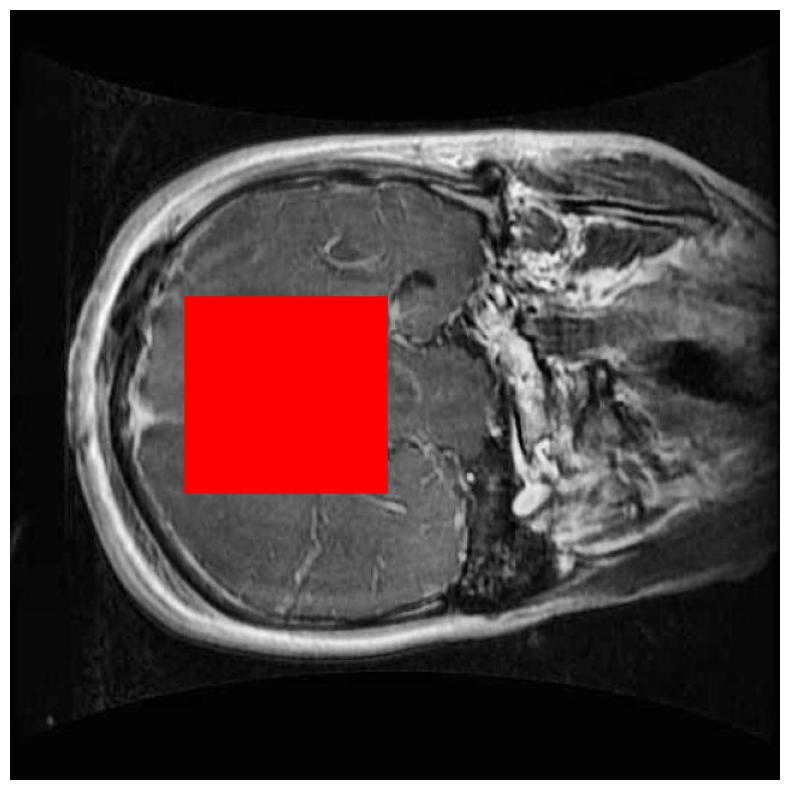

In [16]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load COCO annotations
def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

# Define paths
json_path = 'train/_annotations.coco.json'
img_dir = 'train'

# Load annotations
images, annotations, categories = load_coco_annotations(json_path)

# Select a random image
random_img_id = list(images.keys())[0]
img_info = images[random_img_id]
img_path = os.path.join(img_dir, img_info['file_name'])

# Load the image
image = Image.open(img_path).convert("RGB")

# Create an empty mask
mask = Image.new('L', (img_info['width'], img_info['height']), 0)
draw = ImageDraw.Draw(mask)

# Fill the mask with the segmentation annotations
for ann in annotations:
    if ann['image_id'] == random_img_id:
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly = np.array(seg).reshape((len(seg) // 2, 2))
            draw.polygon([tuple(p) for p in poly], outline=1, fill=1)

mask = np.array(mask, dtype=np.uint8)

# Create a red mask
red_mask = np.zeros((img_info['height'], img_info['width'], 3), dtype=np.uint8)
red_mask[:, :, 0] = mask * 255  # Red channel

# Convert image to numpy array
image_np = np.array(image)

# Overlay the red mask on the image
overlay = image_np.copy()
overlay[mask == 1] = [255, 0, 0]

# Plot the image with the segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()